# Do delays depend more on the destination or the departure?


## 1. Initial analysis


### Step 1: Load the Datasets


In [120]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

original_data = pd.read_csv('../flights.csv', low_memory=False)
airlines_data = pd.read_csv('../airlines.csv', low_memory=False)
airports_data = pd.read_csv('../airports.csv', low_memory=False)


In [121]:
flights_data = original_data.copy()


In [122]:
result = flights_data.groupby(['ORIGIN_AIRPORT'])[
    'DEPARTURE_DELAY'].mean().reset_index()
result = result.sort_values(by='DEPARTURE_DELAY', ascending=False)
result = result.head(10)
result

,ORIGIN_AIRPORT,DEPARTURE_DELAY
234,14222,89.111111
460,ILG,29.391753
219,13964,28.843750
525,MVY,25.907317
453,HYA,23.182927
5,10154,22.857143
29,10581,20.111111
599,STC,18.692308
537,OTH,17.777358
325,ASE,17.587538


In [123]:
result = flights_data.groupby(['DESTINATION_AIRPORT'])[
    'ARRIVAL_DELAY'].mean().reset_index()
result = result.sort_values(by='ARRIVAL_DELAY', ascending=False)
result = result.head(10)
result

,DESTINATION_AIRPORT,ARRIVAL_DELAY
220,13964,26.906250
600,STC,23.025974
461,ILG,21.989474
223,14025,18.000000
612,TTN,17.433901
444,GUM,17.320242
538,OTH,16.740602
519,MQT,16.152027
326,ASE,15.829448
541,PBG,15.288256


In [124]:
mask_origin = ~flights_data['ORIGIN_AIRPORT'].astype(
    str).apply(lambda x: x.isdigit() and len(x) == 5)
mask_destination = ~flights_data['DESTINATION_AIRPORT'].astype(
    str).apply(lambda x: x.isdigit() and len(x) == 5)

# Combine the masks using a logical AND operation
final_mask = mask_origin & mask_destination

# Filter the DataFrame using the combined mask
flights_data = flights_data[final_mask]

### Step 2: Merge Datasets


In [125]:
# Renaming columns in airports_data
airports_data_origin = airports_data.rename(columns=lambda x: x + "_ORIGIN")
airports_data_destination = airports_data.rename(
    columns=lambda x: x + "_DESTINATION")

# Merging with airlines
flights_data = pd.merge(flights_data, airlines_data,
                        left_on='AIRLINE', right_on='IATA_CODE', how='left')


# Merging with airports for departure
flights_data = pd.merge(flights_data, airports_data_origin,
                        left_on='ORIGIN_AIRPORT', right_on='IATA_CODE_ORIGIN', how='left')

# Merging with airports for destination
flights_data = pd.merge(flights_data, airports_data_destination,
                        left_on='DESTINATION_AIRPORT', right_on='IATA_CODE_DESTINATION', how='left')


### Step 3: Data Preprocessing


In [126]:
# You can drop or impute missing values based on your requirement
# TODO: Check if any preprocessing is required for the data
flights_data.dropna(subset=['DEPARTURE_DELAY', 'ARRIVAL_DELAY',
                    'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], inplace=True)

### Step 4: Analyzing Departure Delays


In [127]:
departure_delays = flights_data.groupby(
    'ORIGIN_AIRPORT')['DEPARTURE_DELAY'].mean().reset_index()

### Step 5: Analyzing Arrival Delays


In [128]:
destination_delays = flights_data.groupby('DESTINATION_AIRPORT')[
    'ARRIVAL_DELAY'].mean().reset_index()

### Step 6: Statistical Analysis


In [129]:
t_stat, p_value = ttest_ind(
    departure_delays['DEPARTURE_DELAY'], destination_delays['ARRIVAL_DELAY'])
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 7.295061768883951
P-value: 8.834125079117092e-13


In [130]:
# TODO: DELTE AFTER
print(departure_delays)


    ORIGIN_AIRPORT  DEPARTURE_DELAY
0              ABE         8.687023
1              ABI         5.747647
2              ABQ         8.798552
3              ABR        10.101056
4              ABY         8.756351
..             ...              ...
317            WRG         2.953775
318            WYS         1.375000
319            XNA        11.810889
320            YAK        -6.507692
321            YUM         1.232470

[322 rows x 2 columns]


### Step 7: Visualization


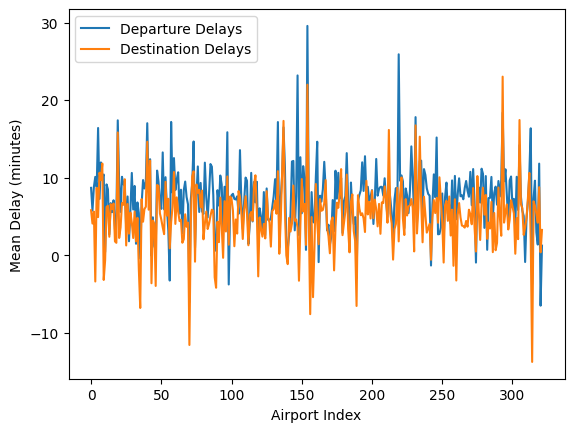

In [131]:
plt.plot(departure_delays['DEPARTURE_DELAY'], label='Departure Delays')
plt.plot(destination_delays['ARRIVAL_DELAY'], label='Destination Delays')
plt.xlabel('Airport Index')  # X-axis label
plt.ylabel('Mean Delay (minutes)')  # Y-axis label
plt.legend()
plt.show()


### Step 8: Conclusion

The low p-value (8.834125079117092e-13) provides strong evidence that there is a statistically significant difference between the means of the departure delays and arrival delays.


## 2. Preprocessing data


In [132]:
flights_data = original_data.copy()
pd.concat([flights_data.isnull().sum(), 100 * flights_data.isnull().sum()/len(flights_data)],
          axis=1).rename(columns={0: 'Missing Records', 1: 'Percentage (%)'})

,Missing Records,Percentage (%)
YEAR,0,0.000000
MONTH,0,0.000000
DAY,0,0.000000
DAY_OF_WEEK,0,0.000000
AIRLINE,0,0.000000
FLIGHT_NUMBER,0,0.000000
TAIL_NUMBER,14721,0.252978
ORIGIN_AIRPORT,0,0.000000
DESTINATION_AIRPORT,0,0.000000
SCHEDULED_DEPARTURE,0,0.000000


In [133]:
flights_data.drop(columns=['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                  'WEATHER_DELAY', 'YEAR', 'TAIL_NUMBER', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'TAXI_IN', 'WHEELS_ON'], inplace=True)
flights_data.dropna(inplace=True)


In [134]:
print(flights_data.dtypes)
print(flights_data.select_dtypes(include=['object', 'category']).columns)

MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
SCHEDULED_ARRIVAL        int64
dtype: object
Index(['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], dtype='object')


In [135]:
# Convert categorical variables
flights_data = pd.get_dummies(
    flights_data, columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])


In [136]:
monthly_counts = flights_data.groupby('MONTH').size()
print(monthly_counts)


MONTH
1     457013
2     407663
3     492138
4     479251
5     489641
6     492847
7     514384
8     503956
9     462153
10    482878
11    462367
12    469717
dtype: int64


In [137]:
flights_data = flights_data[flights_data['MONTH'] == 6]


## 3. Model 1 - Random Forest


### Step 1: Import Necessary Libraries


In [138]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

### Step 2: Split the Data


In [139]:
X = flights_data.drop('DEPARTURE_DELAY', axis=1)
y = flights_data['DEPARTURE_DELAY']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Step 3: Train a Random Forest Model


In [140]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

### Step 4: Evaluate the Model


In [141]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 11.69463349092016


### Step 5: Feature Importance


In [142]:
feature_importances = model.feature_importances_
features = list(X_train.columns)
importances_df = pd.DataFrame(
    {'feature': features, 'importance': feature_importances})
importances_df = importances_df.sort_values('importance', ascending=False)
print(importances_df.head(10))

                 feature  importance
4    SCHEDULED_DEPARTURE    0.664501
5         DEPARTURE_TIME    0.290023
7             WHEELS_OFF    0.033905
12     SCHEDULED_ARRIVAL    0.004059
6               TAXI_OUT    0.000841
13            AIRLINE_AA    0.000813
9           ELAPSED_TIME    0.000770
620   ORIGIN_AIRPORT_SMF    0.000645
3          FLIGHT_NUMBER    0.000600
10              AIR_TIME    0.000580


## 4. Model 2 - TensorFlow and Keras


### Step 1: Import Libraries

In [109]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import layers
import tensorflow as tf

### Step 2: Prepare Inputs and Targets

In [110]:
# Scale the features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Step 3: Build the Neural Network

In [111]:
model = tf.keras.Sequential([
    Input(shape=(scaled_X_train.shape[1],)),  # Input layer
    Dense(256, activation='relu'),  # Hidden layer with ReLU activation
    Dense(128, activation='relu'),  # Another hidden layer
    Dense(64, activation='relu'),  # Another hidden layer
    Dense(32, activation='relu'),  # Another hidden layer
    Dense(1)  # Output layer (for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(scaled_X_train, y_train, epochs=50,
                    batch_size=128, validation_split=0.2)


Epoch 1/50
2465/2465 [==============================] - 7s 3ms/step - loss: 817.9706 - val_loss: 523.8538
Epoch 2/50
2465/2465 [==============================] - 6s 3ms/step - loss: 353.0123 - val_loss: 403.4455
Epoch 3/50
2465/2465 [==============================] - 6s 3ms/step - loss: 261.5017 - val_loss: 298.9360
Epoch 4/50
2465/2465 [==============================] - 6s 3ms/step - loss: 207.8082 - val_loss: 306.7600
Epoch 5/50
2465/2465 [==============================] - 6s 3ms/step - loss: 177.8772 - val_loss: 246.5689
Epoch 6/50
2465/2465 [==============================] - 6s 3ms/step - loss: 162.8739 - val_loss: 249.6037
Epoch 7/50
2465/2465 [==============================] - 7s 3ms/step - loss: 148.9854 - val_loss: 218.6389
Epoch 8/50
2465/2465 [==============================] - 6s 3ms/step - loss: 137.9295 - val_loss: 245.0453
Epoch 9/50
2465/2465 [==============================] - 6s 3ms/step - loss: 126.6744 - val_loss: 202.2493
Epoch 10/50
2465/2465 [=======================

### Step 4: Evaluate the Model

In [119]:
# Evaluate the model on the test set
# Calculate the range of DEPARTURE_DELAY
departure_delay_range = y.max() - y.min()

# Calculate the standard deviation of DEPARTURE_DELAY
departure_delay_std = y.std()
dl_predictions = model.predict(scaled_X_test)
dl_mse = mean_squared_error(y_test, dl_predictions)
variance_of_target = y.var()
loss = model.evaluate(scaled_X_test, y_test)
print(f"Range of DEPARTURE_DELAY: {departure_delay_range}")
print(f"Standard Deviation of DEPARTURE_DELAY: {departure_delay_std}")
print(f"Variance of DEPARTURE_DELAY: {variance_of_target}")
print("The mean squared error of the predictions is:", dl_mse)
print(f'Test Loss: {loss}')


3081/3081 [==============================] - 2s 575us/step - loss: 115.4777
Range of DEPARTURE_DELAY: 1574.0
Standard Deviation of DEPARTURE_DELAY: 43.05389236264149
Variance of DEPARTURE_DELAY: 1853.6376475739196
The mean squared error of the predictions is: 115.4774491076065
Test Loss: 115.47766876220703


### Step 5: Plotting Train, Test, and Validation Graphs:

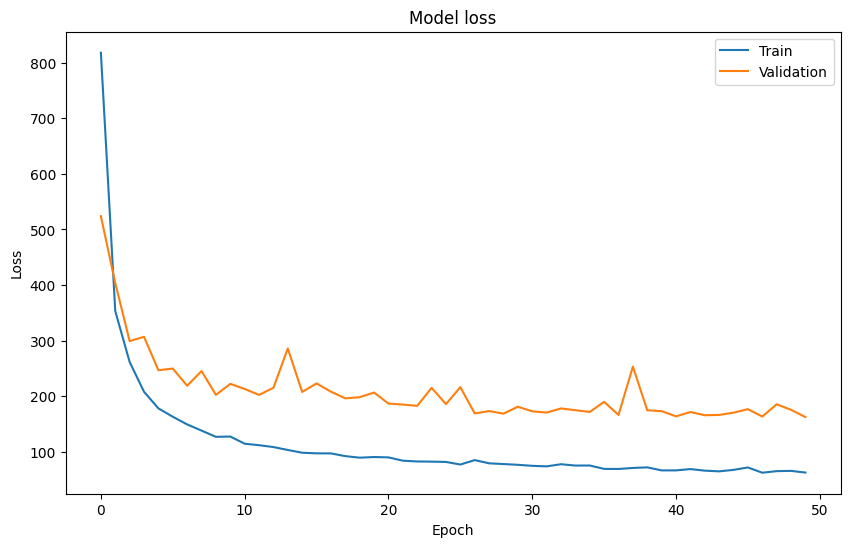

In [113]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


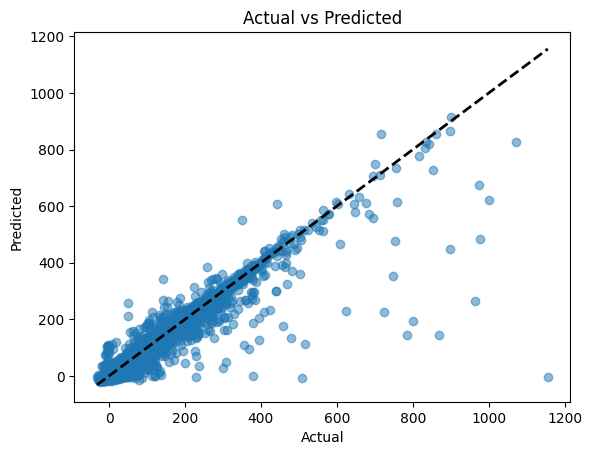

In [115]:
plt.scatter(y_test, dl_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

### Step 5: Feature Importance Analysis

In [114]:
# # Create a SHAP explainer object
# import shap
# explainer = shap.DeepExplainer(model, X_train)

# # Compute SHAP values for a subset of the test data
# shap_values = explainer.shap_values(X_test[:1000])  # Example with the first 1000 test samples

# # Plot the SHAP values for the first prediction
# shap.initjs() # Necessary for visualizing in Jupyter
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test[0])